                     feature  importance
0      Payment_of_Min_Amount  904.914246
1                 Credit_Mix  213.304382
2           Outstanding_Debt   59.385513
3              Interest_Rate   30.276566
4            Num_Credit_Card   22.612881
5        Delay_from_due_date   13.923170
6       Changed_Credit_Limit   12.375536
7          Num_Bank_Accounts    8.831492
8     Num_of_Delayed_Payment    8.066627
9       Num_Credit_Inquiries    7.390299
10     Monthly_Inhand_Salary    6.794808
11             Annual_Income    6.523954
12               Num_of_Loan    6.013589
13       Total_EMI_per_month    5.995248
14               Last_Loan_4    5.849664
15               Last_Loan_8    5.796684
16               Last_Loan_2    5.622798
17               Last_Loan_7    5.605498
18               Last_Loan_6    5.444620
19               Last_Loan_3    5.422507
20               Last_Loan_1    5.277205
21                Occupation    5.273008
22               Last_Loan_5    5.256507
23              

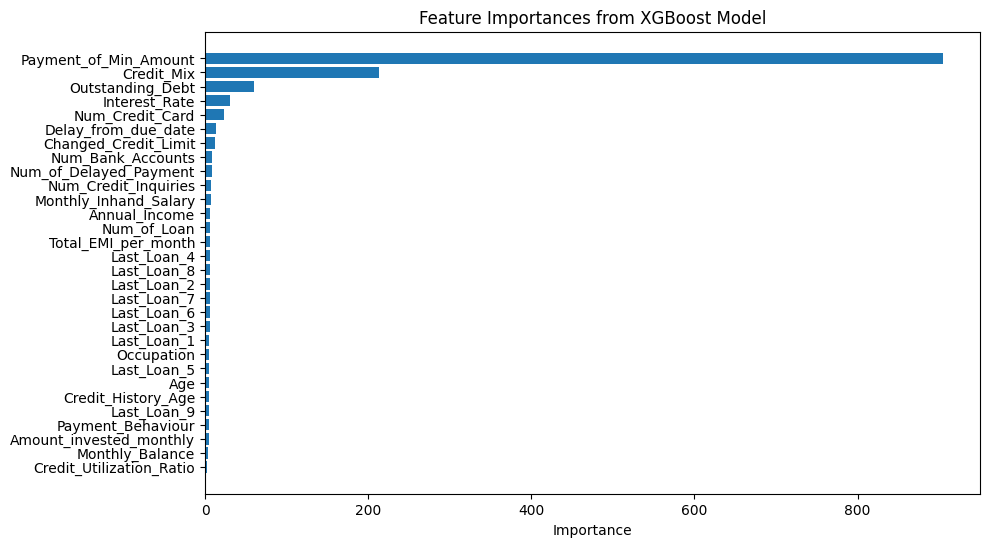

In [13]:
# !pip install evidently
# !pip install boto3
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from evidently.metrics import ColumnDriftMetric
import boto3
db = pd.read_csv("Credit_score_cleaned_data.csv")
db =db.drop(columns=['Customer_ID'])
categorical_columns = db.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    db[col] = label_encoder.fit_transform(db[col])
target = 'Credit_Score'
features = [col for col in db.columns if col != target]
X = db[features]
y = db[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#train
model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42, n_estimators=50)
model.fit(X_train, y_train)
#Features
feature_importances = model.get_booster().get_score(importance_type='gain')
fi_df = pd.DataFrame({
    'feature': list(feature_importances.keys()),
    'importance': list(feature_importances.values())
}).sort_values(by='importance', ascending=False)
fi_df.reset_index(drop=True, inplace=True)
print(fi_df)
plt.figure(figsize=(10, 6))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.xlabel('Importance')
plt.title('Feature Importances from XGBoost Model')
plt.show()



In [46]:

# - Example of using custom drift methods and thresholds for specific columns and the dataset.
# - ColumnDriftMetric(column_name='feature1', stattest='wasserstein', stattest_threshold=0.2): Set custom drift detection method and threshold.
# - DatasetDriftMetric(drift_share=0.7): Set a custom condition for dataset drift based on the share of drifting columns.
# - Example of setting drift detection for all categorical columns: DataDriftPreset(cat_stattest='ks', cat_statest_threshold=0.05).
# - Example of using TestShareOfDriftedColumns to set a custom drift threshold: TestShareOfDriftedColumns(lt=0.5).
# - Example of using drift detection methods for tabular data:
#   - ks: Kolmogorov-Smirnov test for numerical data.
#   - chisquare: Chi-Square test for categorical data with > 2 labels.
#   - z: Z-test for binary data.
#   - wasserstein: Wasserstein distance for numerical data with > 1000 objects.
#   - kl_div: Kullback-Leibler divergence for numerical and categorical data.
#   - psi: Population Stability Index for numerical and categorical data.
#   - jensenshannon: Jensen-Shannon distance for categorical data with > 1000 objects.
#   - anderson: Anderson-Darling test for numerical data.
#   - fisher_exact: Fisher's Exact test for categorical data.
#   - cramer_von_mises: Cramer-Von-Mises test for numerical data.
#   - g-test: G-test for categorical data.
#   - hellinger: Hellinger Distance for numerical and categorical data.
#   - mannw: Mann-Whitney U-rank test for numerical data.
#   - ed: Energy distance for numerical data.
#   - es: Epps-Singleton test for numerical data.
#   - t_test: T-Test for numerical data.
#   - empirical_mmd: Empirical-MMD for numerical data.
#   - TVD: Total-Variation-Distance for categorical data.



In [51]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric

# Load the uploaded dataset
db = pd.read_csv("Credit_score_cleaned_data.csv")

# Drop Customer_ID as it's not useful for model training
db = db.drop(columns=['Customer_ID'])

# Identify categorical columns for encoding
categorical_columns = db.select_dtypes(include=['object']).columns

# Apply Label Encoding to all categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    db[col] = label_encoder.fit_transform(db[col])

# Prepare the data: Define features and target
target = 'Credit_Score'
features = [col for col in db.columns if col != target]

X = db[features]
y = db[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the XGBoost model with reduced boosting rounds for faster training
model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42, n_estimators=50)
model.fit(X_train, y_train)

# Extract feature importance
feature_importances = model.get_booster().get_score(importance_type='gain')

# Convert feature importances into a DataFrame
fi_df = pd.DataFrame({
    'feature': list(feature_importances.keys()),
    'importance': list(feature_importances.values())
}).sort_values(by='importance', ascending=False)

# Reset index
fi_df.reset_index(drop=True, inplace=True)


# Simulate drift by creating a modified version of the current dataset
current_data = X_test.copy()
current_data['Monthly_Inhand_Salary'] = current_data['Monthly_Inhand_Salary'] * np.random.uniform(0.7, 1.3, current_data.shape[0])  # Introduce random changes
current_data['Credit_History_Age'] = current_data['Credit_History_Age'] * np.random.uniform(0.8, 1.2, current_data.shape[0])  # Introduce drift

# Add back target and prediction columns for drift detection
reference_data = X_train.copy()
reference_data[target] = y_train
reference_data['prediction'] = model.predict(X_train)

# Ensure that 'Credit_Score' is not included when making predictions
current_data_no_target = current_data.copy()
current_data_no_target['prediction'] = model.predict(current_data_no_target)

# Add back the target column for drift detection purposes
current_data[target] = y_test
current_data['prediction'] = current_data_no_target['prediction']

# Generate Custom Data Drift Report with custom metrics, including target variable and key features
custom_metrics = [
    ColumnDriftMetric(column_name='Monthly_Inhand_Salary', stattest='ks', stattest_threshold=0.05),
    ColumnDriftMetric(column_name='Credit_History_Age', stattest='wasserstein', stattest_threshold=0.1),
    ColumnDriftMetric(column_name='Credit_Score', stattest='chisquare', stattest_threshold=0.05)
]

custom_drift_report = Report(metrics=custom_metrics)
custom_drift_report.run(reference_data=reference_data, current_data=current_data)
custom_drift_report.save_html('custom_data_drift_report.html')

# Extract individual drift scores from the report
drift_result = custom_drift_report.as_dict()
individual_drift_scores = {}
for metric in drift_result.get('metrics', []):
    if isinstance(metric, dict) and 'result' in metric:
        result = metric.get('result', {})
        column_name = result.get('column_name', '')
        drift_detected = result.get('drift_detected', False)
        stattest_name = result.get('stattest_name', 'unknown')
        p_value = result.get('p_value', None)
        drift_score = result.get('drift_score', None)
        if column_name:
            individual_drift_scores[column_name] = {
                'drift_detected': drift_detected,
                'p_value': p_value,
                'stattest_name': stattest_name,
                'drift_score': drift_score
            }

# Print individual drift scores
for column, score_info in individual_drift_scores.items():
    drift_status = 'Detected' if score_info['drift_detected'] else 'Not Detected'
    p_value_display = score_info['p_value'] if score_info['p_value'] is not None else 'N/A'
    drift_score_display = score_info['drift_score'] if score_info['drift_score'] is not None else 'N/A'
    print(f"Drift for {column}: {drift_status}, p-value: {p_value_display}, stattest: {score_info['stattest_name']}, drift score: {drift_score_display}")

# Setting up alerts based on EvidentlyAI's drift detection results
for column, score_info in individual_drift_scores.items():
    if score_info['drift_detected']:
        status = 'Red'
    elif score_info['p_value'] is not None and float(score_info['p_value']) < 0.1:
        status = 'Amber'
    else:
        status = 'Green'
    print(f"Drift Status for {column}: {status}")


Drift for Monthly_Inhand_Salary: Detected, p-value: N/A, stattest: K-S p_value, drift score: 2.8939205218725353e-05
Drift for Credit_History_Age: Not Detected, p-value: N/A, stattest: Wasserstein distance (normed), drift score: 0.0506862671976453
Drift for Credit_Score: Not Detected, p-value: N/A, stattest: chi-square p_value, drift score: 0.9999135135940294
Drift Status for Monthly_Inhand_Salary: Red
Drift Status for Credit_History_Age: Green
Drift Status for Credit_Score: Green
